# The environment setting is 13-12100 and RTX2070

### 1. Environment Setup

#### 1.1.Import packages

In [1]:
import os
import time
import pandas as pd
import numpy as np
import math
import random
from tqdm import tqdm
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision import models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List, Tuple
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(540446740)
torch.cuda.manual_seed(540446740)

In [36]:
#If cannot run, modify this path
path = os.path.join(os.curdir, "data")

#### 1.2.Define Class and functions

In [3]:
class MultiLabelDataset(Dataset):
    def __init__(self, path: str, transform: 'transform' = None):
        """
        Initializes the dataset class, specifying the path and setting up a transform function.

        Args:
        path: The directory path where the dataset files are stored.
        transform: A transformation function to apply to the images. Default is None.
        """
        self.path = path
        self.train = self.path + '\\train.csv'  
        self.test = self.path + '\\test1.csv' 
        self.predict = self.path + '\\test2.csv' 
        self.data = np.array([])  
        self.label = np.array([])  
        self.transform = transform  

    def __len__(self) -> int:
        """
        Returns the size of the dataset (number of samples).

        Returns:
        int: The number of samples in the dataset.
        """
        if self.data.size == 0:
            raise ValueError('Data not loaded')
        return self.data.shape[0]

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Retrieves the sample and label at the given index.

        Args:
        idx: Index of the sample to retrieve.

        Returns:
        A tuple containing the image data and the corresponding label.
        """
        if self.data.size == 0:
            raise ValueError('Data not loaded')
        if self.label.size > 0:
            label = self.label[idx] 
        else:
            label = -1 
        image = self.data[idx].astype('float')  
        if self.transform:
            image = self.transform(image) 
        return image, label

    def _load_and_process(self, filepath: str) -> Tuple[np.ndarray, np.ndarray]:
        """
        private function, loads and processes data from the specified CSV file.

        Args:
        filepath: The path to the CSV file.

        Returns:
        A tuple containing the feature data and labels.
        """
        df = pd.read_csv(filepath) 
        labels = np.array(df.iloc[:, -1]) 
        features = np.array(df.iloc[:, 1:-1])
        features = features.reshape(features.shape[0], 28, 28, 1)  
        return features, labels

    def loadData(self, mode: str = 'train') -> None:
        """
        Loads the data based on the selected mode.

        Args:
        mode: Mode of the data to load. Choices are 'train', 'test', or 'predict'.
        """
        if mode == 'train':
            self.data, self.label = self._load_and_process(self.train) 
        elif mode == 'test':
            self.data, self.label = self._load_and_process(self.test)
        elif mode == 'predict':
            self.data = pd.read_csv(self.predict).iloc[:, 1:].to_numpy()
            self.data = self.data.reshape(self.data.shape[0], 28, 28, 1)
            self.label = np.array([-1] * self.data.shape[0]) 
        else:
            raise ValueError("Invalid mode. Choose 'train', 'test', or 'predict'.")

    def showImg(self, idx: int = None) -> None:
        """
        Displays an image from the dataset.

        Args:
        idx: Index of the image to display. If None, a random image will be shown.
        """
        if idx is None:
            idx = random.randint(0, self.data.shape[0] - 1)  
        feature = self[idx][0].reshape(self[idx][0].shape[1], self[idx][0].shape[1]) 
        label = self.label[idx] if self.label.size > 0 else np.array([]) 
        plt.figure(figsize=(3, 3))
        plt.imshow(feature, cmap='gray')  
        plt.title("class " + str(label))  
        plt.show()


In [4]:
class Tools():
    @staticmethod
    def cal_mean_std(dataset: np.ndarray) -> Tuple[float, float]:
        """
        Calculate the mean and standard deviation of the dataset.
        
        Args:
        dataset: The dataset from which to calculate mean and standard deviation.
                 The dataset should not be transformed or scaled yet.
        
        Returns:
        The mean and standard deviation of the dataset.
        """
        mean = 0.0
        std = 0.0
        
        for img in dataset.data:
            mean += img.mean() 
            std += img.std()    
        
        mean /= len(dataset)
        std /= len(dataset)
        
        return mean, std

    @staticmethod
    def standardize(dataset: np.ndarray, mean: float, std: float) -> None:
        """
        Apply standardization to the dataset using the given mean and standard deviation.
        
        Args:
        dataset: The dataset to standardize.
        mean: The mean to use for standardization.
        std: The standard deviation to use for standardization.
        """
        dataset.data = (dataset.data - mean) / std

    @staticmethod
    def flatten(dataset: np.ndarray) -> None:
        """
        Flatten each image in the dataset from a 2D array to a 1D array.
        
        Args:
        dataset: The dataset whose images should be flattened.
                 The shape will change from (N, 28, 28, 1) to (N, 28*28).
        """
        dataset.data = dataset.data.reshape(dataset.data.shape[0], 28*28)


In [5]:
## dl model
class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.4)
        )
        self.residual = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=1, stride=4, padding=0),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        residual = self.residual(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x += residual  # ResNet Connection
        x = x.view(x.size(0), -1)
        output = self.classifier(x)
        return output

In [6]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        """
        Initializes the FeatureExtractor module, which extracts features from images
        using the first three convolutional layers of the pre-trained model 
        """
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            model.conv1,
            model.conv2,
            model.conv3,
        )
        self.Linear = nn.Sequential(
            nn.Linear(128 * 3 * 3, 128)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) 
        x = self.Linear(x)
        return x

def extract_features(loader, model):
    """
    Extracts features from a dataset.
    """
    model.to(device)
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, label in loader:
            images, label = images.to(device).float(), label.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            labels.append(label.cpu().numpy())
    
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

In [37]:
def cross_validate_model(model_class:'model', param_grid:dict, X:np.ndarray, y:np.ndarray, k:int = 5) -> dict:
    """
    function to do cross validation with grid search
    
    Args:
    model_class: The machine learning model class (e.g., RandomForestClassifier).
    param_grid: A dictionary of hyperparameters to evaluate.
    X: Feature matrix.
    y: Labels.
    k: Number of folds for cross-validation.

    Returns:
    A dictionary containing accuracy and F1 scores for each hyperparameter combination.
    """
    results = []
    kf = KFold(n_splits=k)
    param_list = list(ParameterGrid(param_grid))

    for params in param_list:
        accuracy_list = []
        f1_list = []
        training_time = 0
        inference_time = 0

        print(f"Hyperparameters: {params}")

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = model_class(**params)

            # Measure training time
            start_time = time.perf_counter()
            model.fit(X_train, y_train)
            training_time += time.perf_counter() - start_time

            # Measure inference time
            start_time = time.perf_counter()
            y_pred = model.predict(X_test)
            inference_time += time.perf_counter() - start_time

            # Calculate metrics
            accuracy_list.append(accuracy_score(y_test, y_pred))
            f1_list.append(f1_score(y_test, y_pred, average='weighted'))

        # Average metrics over k folds
        avg_accuracy = np.mean(accuracy_list)
        avg_f1 = np.mean(f1_list)
        avg_training_time = training_time / k
        avg_inference_time = inference_time / k

        print(f"Average Test Accuracy: {avg_accuracy:.4f}, Average Test F1 Score: {avg_f1:.4f}")
        print(f"Average Training Time per Fold: {avg_training_time:.4f} seconds")
        print(f"Average Inference Time per Fold: {avg_inference_time:.4f} seconds\n")

        # Store results
        results.append({
            'accuracy': avg_accuracy,
            'f1_score': avg_f1,
            'training_time': avg_training_time,
            'inference_time': avg_inference_time
        })

    return results

In [8]:
def plot_heatmaps(results:dict, row_name:str, row_values:List, col_name:str, col_values:List) -> None:
    """
    Plot heatmaps 
    Args:
    results: The dictionary containing the results.
    row_name: The name of the hyperparameter corresponding to the rows.
    row_values: List of values for the row hyperparameter.
    col_name: The name of the hyperparameter corresponding to the columns.
    col_values: List of values for the column hyperparameter.
    """
    accuracy_matrix = np.array([metrics['accuracy'] for metrics in results]).reshape((len(col_values), len(row_values)))
    f1_matrix = np.array([metrics['f1_score'] for metrics in results]).reshape((len(col_values), len(row_values)))
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    sns.heatmap(accuracy_matrix, xticklabels=row_values, yticklabels=col_values, cmap='coolwarm', annot=True, fmt='.4f', ax=ax[0], cbar_kws={'label': 'Accuracy'})
    ax[0].set_title('Accuracy Heatmap')
    ax[0].set_xlabel(row_name)
    ax[0].set_ylabel(col_name)
    
    sns.heatmap(f1_matrix, xticklabels=row_values, yticklabels=col_values, cmap='coolwarm', annot=True, fmt='.4f', ax=ax[1], cbar_kws={'label': 'F1-score'})
    ax[1].set_title('F1-score Heatmap')
    ax[1].set_xlabel(row_name)
    ax[1].set_ylabel(col_name)
    
    plt.tight_layout()
    plt.show()


In [9]:
def train_model(model:'model') -> None:
    """
    Trains a machine learning model and evaluates its performance, including the training time, inference time,
    accuracy, and F1-score.
    """
    start_time = time.perf_counter()
    model.fit(train_features, train_labels)
    end_time = time.perf_counter()
    training_time = end_time - start_time
    print(f"training time: {training_time:.6f} seconds")
    
    start_time = time.perf_counter()
    test_pred = model.predict(test_features)
    end_time = time.perf_counter()
    inference_time = end_time - start_time
    print(f"inference time: {inference_time:.6f} seconds")
    accuracy = accuracy_score(test_labels, test_pred)
    f1 = f1_score(test_labels, test_pred, average='weighted')
    print(f"Test Accuracy: {accuracy}, Test F1-Score: {f1}")

### 2.Load data and do simple proprecessing (standardization and Random Horizaontal Flip)

In [10]:
batch_size = 256
#define tarnsform(used for deep learning) 
transform = transforms.Compose([transforms.ToTensor(),   
                                transforms.RandomHorizontalFlip(p=0.5)])
#full sample training
train_dataset = MultiLabelDataset(path, transform = transform)
train_dataset.loadData('train')
mean, std = Tools.cal_mean_std(train_dataset)
Tools.standardize(train_dataset, mean, std)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

#test
test_transform = transforms.Compose([transforms.ToTensor()])
test_dataset = MultiLabelDataset(path, transform = test_transform)
test_dataset.loadData('test')
mean, std = Tools.cal_mean_std(test_dataset)
Tools.standardize(test_dataset, mean, std)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

#predict
predict_dataset = MultiLabelDataset(path, transform = test_transform)
predict_dataset.loadData('predict')
mean, std = Tools.cal_mean_std(predict_dataset)
Tools.standardize(predict_dataset, mean, std)
predict_loader = DataLoader(predict_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

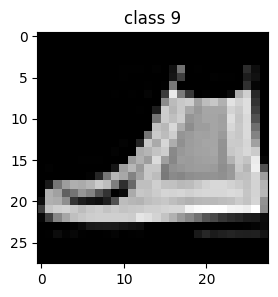

In [11]:
train_dataset.showImg()

#### 2.1.Train dl model

In [12]:
num_epochs = 128
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

model = ResNet() 
model.cuda()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    train_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")
    
    for images, labels in train_tqdm:
        images, labels = images.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    valid_tqdm = tqdm(test_loader, desc=f"Epoch {epoch+1} Validation")
    
    with torch.no_grad():
        for images, labels in valid_tqdm:
            images, labels = images.to(device).float(), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            valid_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    valid_losses.append(valid_loss / len(test_loader))
    valid_accuracies.append(correct / total)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Validation Loss: {valid_losses[-1]}, Validation Accuracy: {valid_accuracies[-1]}')


Epoch 1 Validation: 100%|██████████| 8/8 [00:00<00:00, 256.93it/s]


Epoch 1, Train Loss: 0.8823144082295693, Train Accuracy: 0.6706333333333333, Validation Loss: 0.5934894308447838, Validation Accuracy: 0.768


Epoch 2 Validation: 100%|██████████| 8/8 [00:00<00:00, 140.94it/s]


Epoch 2, Train Loss: 0.5935697464619653, Train Accuracy: 0.7765666666666666, Validation Loss: 0.5040313638746738, Validation Accuracy: 0.8105


Epoch 3 Validation: 100%|██████████| 8/8 [00:00<00:00, 255.93it/s]


Epoch 3, Train Loss: 0.5206455378714254, Train Accuracy: 0.807, Validation Loss: 0.43273353949189186, Validation Accuracy: 0.8445


Epoch 4 Validation: 100%|██████████| 8/8 [00:00<00:00, 170.91it/s]


Epoch 4, Train Loss: 0.4690082126249701, Train Accuracy: 0.8250666666666666, Validation Loss: 0.4008869417011738, Validation Accuracy: 0.8475


Epoch 5 Validation: 100%|██████████| 8/8 [00:00<00:00, 256.00it/s]


Epoch 5, Train Loss: 0.4427386327820309, Train Accuracy: 0.8362, Validation Loss: 0.37462250515818596, Validation Accuracy: 0.852


Epoch 6 Validation: 100%|██████████| 8/8 [00:00<00:00, 170.88it/s]


Epoch 6, Train Loss: 0.41976049353005523, Train Accuracy: 0.8435666666666667, Validation Loss: 0.3540031723678112, Validation Accuracy: 0.8635


Epoch 7 Validation: 100%|██████████| 8/8 [00:00<00:00, 254.60it/s]


Epoch 7, Train Loss: 0.40266448436147073, Train Accuracy: 0.8525333333333334, Validation Loss: 0.3304241821169853, Validation Accuracy: 0.8675


Epoch 8 Validation: 100%|██████████| 8/8 [00:00<00:00, 157.33it/s]


Epoch 8, Train Loss: 0.38365826831530714, Train Accuracy: 0.8574666666666667, Validation Loss: 0.3141709975898266, Validation Accuracy: 0.8795


Epoch 9 Validation: 100%|██████████| 8/8 [00:00<00:00, 229.79it/s]


Epoch 9, Train Loss: 0.37653585056127126, Train Accuracy: 0.8625666666666667, Validation Loss: 0.27875345945358276, Validation Accuracy: 0.893


Epoch 10 Validation: 100%|██████████| 8/8 [00:00<00:00, 256.46it/s]


Epoch 10, Train Loss: 0.3678962560528416, Train Accuracy: 0.8646333333333334, Validation Loss: 0.2945862840861082, Validation Accuracy: 0.881


Epoch 11 Validation: 100%|██████████| 8/8 [00:00<00:00, 170.68it/s]


Epoch 11, Train Loss: 0.35243971469038626, Train Accuracy: 0.8720666666666667, Validation Loss: 0.2848129943013191, Validation Accuracy: 0.8895


Epoch 12 Validation: 100%|██████████| 8/8 [00:00<00:00, 203.39it/s]


Epoch 12, Train Loss: 0.34819346274864876, Train Accuracy: 0.8708333333333333, Validation Loss: 0.265529353171587, Validation Accuracy: 0.894


Epoch 13 Validation: 100%|██████████| 8/8 [00:00<00:00, 256.03it/s]


Epoch 13, Train Loss: 0.3427744813389697, Train Accuracy: 0.8723, Validation Loss: 0.2662642151117325, Validation Accuracy: 0.8945


Epoch 14 Validation: 100%|██████████| 8/8 [00:00<00:00, 255.19it/s]


Epoch 14, Train Loss: 0.33513910664340196, Train Accuracy: 0.8762, Validation Loss: 0.2589466776698828, Validation Accuracy: 0.8975


Epoch 15 Validation: 100%|██████████| 8/8 [00:00<00:00, 194.50it/s]


Epoch 15, Train Loss: 0.33204464892209584, Train Accuracy: 0.8775666666666667, Validation Loss: 0.2559505235403776, Validation Accuracy: 0.8995


Epoch 16 Validation: 100%|██████████| 8/8 [00:00<00:00, 162.47it/s]


Epoch 16, Train Loss: 0.3219895775161557, Train Accuracy: 0.8805666666666667, Validation Loss: 0.25051150284707546, Validation Accuracy: 0.9065


Epoch 17 Validation: 100%|██████████| 8/8 [00:00<00:00, 180.17it/s]


Epoch 17, Train Loss: 0.32072619841260425, Train Accuracy: 0.8826666666666667, Validation Loss: 0.24925978481769562, Validation Accuracy: 0.902


Epoch 18 Validation: 100%|██████████| 8/8 [00:00<00:00, 242.42it/s]


Epoch 18, Train Loss: 0.31247097746295444, Train Accuracy: 0.8855333333333333, Validation Loss: 0.2508124653249979, Validation Accuracy: 0.899


Epoch 19 Validation: 100%|██████████| 8/8 [00:00<00:00, 354.24it/s]


Epoch 19, Train Loss: 0.3083359831470554, Train Accuracy: 0.8873333333333333, Validation Loss: 0.229946531355381, Validation Accuracy: 0.908


Epoch 20 Validation: 100%|██████████| 8/8 [00:00<00:00, 229.06it/s]


Epoch 20, Train Loss: 0.3034965197666217, Train Accuracy: 0.8900666666666667, Validation Loss: 0.22123495675623417, Validation Accuracy: 0.912


Epoch 21 Validation: 100%|██████████| 8/8 [00:00<00:00, 192.60it/s]


Epoch 21, Train Loss: 0.2994940408458144, Train Accuracy: 0.8892333333333333, Validation Loss: 0.2592040468007326, Validation Accuracy: 0.903


Epoch 22 Validation: 100%|██████████| 8/8 [00:00<00:00, 167.07it/s]


Epoch 22, Train Loss: 0.29270913666587767, Train Accuracy: 0.8904, Validation Loss: 0.23017065413296223, Validation Accuracy: 0.915


Epoch 23 Validation: 100%|██████████| 8/8 [00:00<00:00, 314.95it/s]


Epoch 23, Train Loss: 0.28899024016523767, Train Accuracy: 0.8917666666666667, Validation Loss: 0.247668681666255, Validation Accuracy: 0.904


Epoch 24 Validation: 100%|██████████| 8/8 [00:00<00:00, 169.35it/s]


Epoch 24, Train Loss: 0.2859559748637474, Train Accuracy: 0.8927666666666667, Validation Loss: 0.23031276278197765, Validation Accuracy: 0.91


Epoch 25 Validation: 100%|██████████| 8/8 [00:00<00:00, 255.96it/s]


Epoch 25, Train Loss: 0.2869851485021033, Train Accuracy: 0.8933666666666666, Validation Loss: 0.21963420696556568, Validation Accuracy: 0.9185


Epoch 26 Validation: 100%|██████████| 8/8 [00:00<00:00, 169.17it/s]


Epoch 26, Train Loss: 0.27786792581111697, Train Accuracy: 0.8964333333333333, Validation Loss: 0.2391980066895485, Validation Accuracy: 0.91


Epoch 27 Validation: 100%|██████████| 8/8 [00:00<00:00, 256.02it/s]


Epoch 27, Train Loss: 0.27848862711403327, Train Accuracy: 0.8971333333333333, Validation Loss: 0.22269759140908718, Validation Accuracy: 0.916


Epoch 28 Validation: 100%|██████████| 8/8 [00:00<00:00, 170.72it/s]


Epoch 28, Train Loss: 0.2757129878815958, Train Accuracy: 0.8971, Validation Loss: 0.21871474385261536, Validation Accuracy: 0.9205


Epoch 29 Validation: 100%|██████████| 8/8 [00:00<00:00, 170.87it/s]


Epoch 29, Train Loss: 0.2767664164431014, Train Accuracy: 0.8976666666666666, Validation Loss: 0.21640604734420776, Validation Accuracy: 0.923


Epoch 30 Validation: 100%|██████████| 8/8 [00:00<00:00, 256.04it/s]


Epoch 30, Train Loss: 0.2739450902504436, Train Accuracy: 0.8976333333333333, Validation Loss: 0.22399978712201118, Validation Accuracy: 0.9205


Epoch 31 Validation: 100%|██████████| 8/8 [00:00<00:00, 180.77it/s]


Epoch 31, Train Loss: 0.26926142179359824, Train Accuracy: 0.8990333333333334, Validation Loss: 0.21833411231637, Validation Accuracy: 0.9205


Epoch 32 Validation: 100%|██████████| 8/8 [00:00<00:00, 256.02it/s]


Epoch 32, Train Loss: 0.26609280648625505, Train Accuracy: 0.9000333333333334, Validation Loss: 0.22546448186039925, Validation Accuracy: 0.92


Epoch 33 Validation: 100%|██████████| 8/8 [00:00<00:00, 170.53it/s]


Epoch 33, Train Loss: 0.26382716252642163, Train Accuracy: 0.9022666666666667, Validation Loss: 0.2147951852530241, Validation Accuracy: 0.927


Epoch 34 Validation: 100%|██████████| 8/8 [00:00<00:00, 255.99it/s]


Epoch 34, Train Loss: 0.2635908771495698, Train Accuracy: 0.9015333333333333, Validation Loss: 0.2216839361935854, Validation Accuracy: 0.9225


Epoch 35 Validation: 100%|██████████| 8/8 [00:00<00:00, 170.91it/s]


Epoch 35, Train Loss: 0.2635360076013258, Train Accuracy: 0.9024333333333333, Validation Loss: 0.21900449320673943, Validation Accuracy: 0.9195


Epoch 36 Validation: 100%|██████████| 8/8 [00:00<00:00, 225.33it/s]


Epoch 36, Train Loss: 0.258633724271746, Train Accuracy: 0.9045333333333333, Validation Loss: 0.23470734059810638, Validation Accuracy: 0.916


Epoch 37 Validation: 100%|██████████| 8/8 [00:00<00:00, 256.08it/s]


Epoch 37, Train Loss: 0.25753094445345764, Train Accuracy: 0.9037666666666667, Validation Loss: 0.21896509267389774, Validation Accuracy: 0.918


Epoch 38 Validation: 100%|██████████| 8/8 [00:00<00:00, 256.47it/s]


Epoch 38, Train Loss: 0.25298350575869366, Train Accuracy: 0.9044666666666666, Validation Loss: 0.22966448962688446, Validation Accuracy: 0.92


Epoch 39 Validation: 100%|██████████| 8/8 [00:00<00:00, 170.87it/s]


Epoch 39, Train Loss: 0.25146857737484624, Train Accuracy: 0.9062333333333333, Validation Loss: 0.2142824660986662, Validation Accuracy: 0.922


Epoch 40 Validation: 100%|██████████| 8/8 [00:00<00:00, 256.47it/s]


Epoch 40, Train Loss: 0.24924853583008555, Train Accuracy: 0.9056333333333333, Validation Loss: 0.21872222423553467, Validation Accuracy: 0.9225


Epoch 41 Validation: 100%|██████████| 8/8 [00:00<00:00, 182.74it/s]


Epoch 41, Train Loss: 0.24945179695042513, Train Accuracy: 0.9068, Validation Loss: 0.21388568170368671, Validation Accuracy: 0.928


Epoch 42 Validation: 100%|██████████| 8/8 [00:00<00:00, 228.76it/s]


Epoch 42, Train Loss: 0.24825978992601572, Train Accuracy: 0.9082666666666667, Validation Loss: 0.2067458424717188, Validation Accuracy: 0.926


Epoch 43 Validation: 100%|██████████| 8/8 [00:00<00:00, 256.11it/s]


Epoch 43, Train Loss: 0.24766085290555226, Train Accuracy: 0.9084333333333333, Validation Loss: 0.20098804496228695, Validation Accuracy: 0.9275


Epoch 44 Validation: 100%|██████████| 8/8 [00:00<00:00, 245.23it/s]


Epoch 44, Train Loss: 0.2462864497960624, Train Accuracy: 0.9084666666666666, Validation Loss: 0.21889468282461166, Validation Accuracy: 0.929


Epoch 45 Validation: 100%|██████████| 8/8 [00:00<00:00, 196.10it/s]


Epoch 45, Train Loss: 0.24168631226076917, Train Accuracy: 0.9098666666666667, Validation Loss: 0.21319052018225193, Validation Accuracy: 0.926


Epoch 46 Validation: 100%|██████████| 8/8 [00:00<00:00, 181.86it/s]


Epoch 46, Train Loss: 0.24687578503863286, Train Accuracy: 0.9077333333333333, Validation Loss: 0.20213906280696392, Validation Accuracy: 0.93


Epoch 47 Validation: 100%|██████████| 8/8 [00:00<00:00, 196.71it/s]


Epoch 47, Train Loss: 0.24043573192873244, Train Accuracy: 0.91, Validation Loss: 0.21734200790524483, Validation Accuracy: 0.9245


Epoch 48 Validation: 100%|██████████| 8/8 [00:00<00:00, 149.33it/s]


Epoch 48, Train Loss: 0.24120421524522667, Train Accuracy: 0.9097333333333333, Validation Loss: 0.22194525972008705, Validation Accuracy: 0.924


Epoch 49 Validation: 100%|██████████| 8/8 [00:00<00:00, 175.38it/s]


Epoch 49, Train Loss: 0.24087471540196467, Train Accuracy: 0.9112666666666667, Validation Loss: 0.20656102523207664, Validation Accuracy: 0.9275


Epoch 50 Validation: 100%|██████████| 8/8 [00:00<00:00, 139.36it/s]


Epoch 50, Train Loss: 0.23275503762445207, Train Accuracy: 0.9138, Validation Loss: 0.20816952548921108, Validation Accuracy: 0.927


Epoch 51 Validation: 100%|██████████| 8/8 [00:00<00:00, 380.90it/s]


Epoch 51, Train Loss: 0.23627890551746902, Train Accuracy: 0.912, Validation Loss: 0.20748970657587051, Validation Accuracy: 0.9265


Epoch 52 Validation: 100%|██████████| 8/8 [00:00<00:00, 253.85it/s]


Epoch 52, Train Loss: 0.23418060071387534, Train Accuracy: 0.9136333333333333, Validation Loss: 0.20131664909422398, Validation Accuracy: 0.934


Epoch 53 Validation: 100%|██████████| 8/8 [00:00<00:00, 211.31it/s]


Epoch 53, Train Loss: 0.2342208739433248, Train Accuracy: 0.9117666666666666, Validation Loss: 0.19860733300447464, Validation Accuracy: 0.928


Epoch 54 Validation: 100%|██████████| 8/8 [00:00<00:00, 384.57it/s]


Epoch 54, Train Loss: 0.23028211529224607, Train Accuracy: 0.9142666666666667, Validation Loss: 0.1888427771627903, Validation Accuracy: 0.9385


Epoch 55 Validation: 100%|██████████| 8/8 [00:00<00:00, 221.53it/s]


Epoch 55, Train Loss: 0.229703546612192, Train Accuracy: 0.913, Validation Loss: 0.20459310337901115, Validation Accuracy: 0.9285


Epoch 56 Validation: 100%|██████████| 8/8 [00:00<00:00, 250.93it/s]


Epoch 56, Train Loss: 0.2257207581236706, Train Accuracy: 0.9146666666666666, Validation Loss: 0.20248534716665745, Validation Accuracy: 0.934


Epoch 57 Validation: 100%|██████████| 8/8 [00:00<00:00, 167.39it/s]


Epoch 57, Train Loss: 0.22695221900308538, Train Accuracy: 0.9162, Validation Loss: 0.20126529783010483, Validation Accuracy: 0.936


Epoch 58 Validation: 100%|██████████| 8/8 [00:00<00:00, 224.49it/s]


Epoch 58, Train Loss: 0.2233993252581459, Train Accuracy: 0.9158666666666667, Validation Loss: 0.20758980885148048, Validation Accuracy: 0.9325


Epoch 59 Validation: 100%|██████████| 8/8 [00:00<00:00, 193.09it/s]


Epoch 59, Train Loss: 0.22597308377972095, Train Accuracy: 0.9173, Validation Loss: 0.20525571703910828, Validation Accuracy: 0.9345


Epoch 60 Validation: 100%|██████████| 8/8 [00:00<00:00, 272.15it/s]


Epoch 60, Train Loss: 0.2244804504690534, Train Accuracy: 0.9175, Validation Loss: 0.20180991478264332, Validation Accuracy: 0.934


Epoch 61 Validation: 100%|██████████| 8/8 [00:00<00:00, 196.97it/s]


Epoch 61, Train Loss: 0.22629793524994687, Train Accuracy: 0.9168, Validation Loss: 0.20977982319891453, Validation Accuracy: 0.93


Epoch 62 Validation: 100%|██████████| 8/8 [00:00<00:00, 185.41it/s]


Epoch 62, Train Loss: 0.22191348520375914, Train Accuracy: 0.9158333333333334, Validation Loss: 0.19447594694793224, Validation Accuracy: 0.935


Epoch 63 Validation: 100%|██████████| 8/8 [00:00<00:00, 171.07it/s]


Epoch 63, Train Loss: 0.22416311313035125, Train Accuracy: 0.9154333333333333, Validation Loss: 0.20451220124959946, Validation Accuracy: 0.9305


Epoch 64 Validation: 100%|██████████| 8/8 [00:00<00:00, 254.01it/s]


Epoch 64, Train Loss: 0.21723527467604412, Train Accuracy: 0.9179666666666667, Validation Loss: 0.20095783472061157, Validation Accuracy: 0.932


Epoch 65 Validation: 100%|██████████| 8/8 [00:00<00:00, 249.30it/s]


Epoch 65, Train Loss: 0.2164256299324965, Train Accuracy: 0.9200333333333334, Validation Loss: 0.20064760744571686, Validation Accuracy: 0.9355


Epoch 66 Validation: 100%|██████████| 8/8 [00:00<00:00, 160.38it/s]


Epoch 66, Train Loss: 0.2175039474110482, Train Accuracy: 0.9195333333333333, Validation Loss: 0.2117217853665352, Validation Accuracy: 0.9295


Epoch 67 Validation: 100%|██████████| 8/8 [00:00<00:00, 168.28it/s]


Epoch 67, Train Loss: 0.2161902540947421, Train Accuracy: 0.9215333333333333, Validation Loss: 0.19889860972762108, Validation Accuracy: 0.9355


Epoch 68 Validation: 100%|██████████| 8/8 [00:00<00:00, 209.00it/s]


Epoch 68, Train Loss: 0.21781380253575616, Train Accuracy: 0.9189666666666667, Validation Loss: 0.2064985502511263, Validation Accuracy: 0.93


Epoch 69 Validation: 100%|██████████| 8/8 [00:00<00:00, 212.11it/s]


Epoch 69, Train Loss: 0.21544217447734484, Train Accuracy: 0.9204333333333333, Validation Loss: 0.19092358835041523, Validation Accuracy: 0.9365


Epoch 70 Validation: 100%|██████████| 8/8 [00:00<00:00, 249.34it/s]


Epoch 70, Train Loss: 0.21400110470920297, Train Accuracy: 0.9199, Validation Loss: 0.19819432497024536, Validation Accuracy: 0.932


Epoch 71 Validation: 100%|██████████| 8/8 [00:00<00:00, 138.44it/s]


Epoch 71, Train Loss: 0.21135081634935687, Train Accuracy: 0.9197, Validation Loss: 0.20303454622626305, Validation Accuracy: 0.935


Epoch 72 Validation: 100%|██████████| 8/8 [00:00<00:00, 263.69it/s]


Epoch 72, Train Loss: 0.21093409843111444, Train Accuracy: 0.9203666666666667, Validation Loss: 0.1990505252033472, Validation Accuracy: 0.9375


Epoch 73 Validation: 100%|██████████| 8/8 [00:00<00:00, 344.66it/s]


Epoch 73, Train Loss: 0.21069719901276848, Train Accuracy: 0.9192, Validation Loss: 0.20615431293845177, Validation Accuracy: 0.9345


Epoch 74 Validation: 100%|██████████| 8/8 [00:00<00:00, 149.31it/s]


Epoch 74, Train Loss: 0.21216681962674958, Train Accuracy: 0.9205666666666666, Validation Loss: 0.20110218599438667, Validation Accuracy: 0.938


Epoch 75 Validation: 100%|██████████| 8/8 [00:00<00:00, 174.44it/s]


Epoch 75, Train Loss: 0.2096519998700942, Train Accuracy: 0.9197, Validation Loss: 0.2083214484155178, Validation Accuracy: 0.928


Epoch 76 Validation: 100%|██████████| 8/8 [00:00<00:00, 219.48it/s]


Epoch 76, Train Loss: 0.20713868863501791, Train Accuracy: 0.9226, Validation Loss: 0.20670722238719463, Validation Accuracy: 0.9335


Epoch 77 Validation: 100%|██████████| 8/8 [00:00<00:00, 215.88it/s]


Epoch 77, Train Loss: 0.20731080310829617, Train Accuracy: 0.9234666666666667, Validation Loss: 0.20042402483522892, Validation Accuracy: 0.937


Epoch 78 Validation: 100%|██████████| 8/8 [00:00<00:00, 232.85it/s]


Epoch 78, Train Loss: 0.20819828008948746, Train Accuracy: 0.9209, Validation Loss: 0.1926584243774414, Validation Accuracy: 0.933


Epoch 79 Validation: 100%|██████████| 8/8 [00:00<00:00, 240.99it/s]


Epoch 79, Train Loss: 0.20953823799677826, Train Accuracy: 0.9211, Validation Loss: 0.20364327356219292, Validation Accuracy: 0.9355


Epoch 80 Validation: 100%|██████████| 8/8 [00:00<00:00, 205.40it/s]


Epoch 80, Train Loss: 0.2057673318658845, Train Accuracy: 0.9222666666666667, Validation Loss: 0.2009069062769413, Validation Accuracy: 0.933


Epoch 81 Validation: 100%|██████████| 8/8 [00:00<00:00, 180.43it/s]


Epoch 81, Train Loss: 0.20716214590406012, Train Accuracy: 0.9225333333333333, Validation Loss: 0.19541265815496445, Validation Accuracy: 0.9315


Epoch 82 Validation: 100%|██████████| 8/8 [00:00<00:00, 209.26it/s]


Epoch 82, Train Loss: 0.2078178122134532, Train Accuracy: 0.9228, Validation Loss: 0.1946579422801733, Validation Accuracy: 0.9385


Epoch 83 Validation: 100%|██████████| 8/8 [00:00<00:00, 214.28it/s]


Epoch 83, Train Loss: 0.20605644861520347, Train Accuracy: 0.9241666666666667, Validation Loss: 0.19663412123918533, Validation Accuracy: 0.936


Epoch 84 Validation: 100%|██████████| 8/8 [00:00<00:00, 225.99it/s]


Epoch 84, Train Loss: 0.2035622553489471, Train Accuracy: 0.9239666666666667, Validation Loss: 0.20286610163748264, Validation Accuracy: 0.931


Epoch 85 Validation: 100%|██████████| 8/8 [00:00<00:00, 212.04it/s]


Epoch 85, Train Loss: 0.2016079427705983, Train Accuracy: 0.9247, Validation Loss: 0.1869763284921646, Validation Accuracy: 0.935


Epoch 86 Validation: 100%|██████████| 8/8 [00:00<00:00, 191.10it/s]


Epoch 86, Train Loss: 0.19828229043948448, Train Accuracy: 0.9255666666666666, Validation Loss: 0.19446264393627644, Validation Accuracy: 0.937


Epoch 87 Validation: 100%|██████████| 8/8 [00:00<00:00, 255.84it/s]


Epoch 87, Train Loss: 0.20381933813756806, Train Accuracy: 0.9251666666666667, Validation Loss: 0.1907798834145069, Validation Accuracy: 0.937


Epoch 88 Validation: 100%|██████████| 8/8 [00:00<00:00, 258.77it/s]


Epoch 88, Train Loss: 0.20187207949111016, Train Accuracy: 0.9237333333333333, Validation Loss: 0.20193429477512836, Validation Accuracy: 0.936


Epoch 89 Validation: 100%|██████████| 8/8 [00:00<00:00, 195.20it/s]


Epoch 89, Train Loss: 0.1978676601991815, Train Accuracy: 0.9251333333333334, Validation Loss: 0.18925412464886904, Validation Accuracy: 0.9365


Epoch 90 Validation: 100%|██████████| 8/8 [00:00<00:00, 230.61it/s]


Epoch 90, Train Loss: 0.19685960033813776, Train Accuracy: 0.9268, Validation Loss: 0.19743071123957634, Validation Accuracy: 0.9375


Epoch 91 Validation: 100%|██████████| 8/8 [00:00<00:00, 153.29it/s]


Epoch 91, Train Loss: 0.19379208492651834, Train Accuracy: 0.9269333333333334, Validation Loss: 0.19588176533579826, Validation Accuracy: 0.9355


Epoch 92 Validation: 100%|██████████| 8/8 [00:00<00:00, 192.21it/s]


Epoch 92, Train Loss: 0.19614604604825125, Train Accuracy: 0.926, Validation Loss: 0.18652400095015764, Validation Accuracy: 0.94


Epoch 93 Validation: 100%|██████████| 8/8 [00:00<00:00, 258.90it/s]


Epoch 93, Train Loss: 0.1926540622203532, Train Accuracy: 0.9286666666666666, Validation Loss: 0.2054722961038351, Validation Accuracy: 0.9355


Epoch 94 Validation: 100%|██████████| 8/8 [00:00<00:00, 190.28it/s]


Epoch 94, Train Loss: 0.1945964617623111, Train Accuracy: 0.9273, Validation Loss: 0.18471449986100197, Validation Accuracy: 0.9385


Epoch 95 Validation: 100%|██████████| 8/8 [00:00<00:00, 217.90it/s]


Epoch 95, Train Loss: 0.19797465448283544, Train Accuracy: 0.925, Validation Loss: 0.1933609778061509, Validation Accuracy: 0.937


Epoch 96 Validation: 100%|██████████| 8/8 [00:00<00:00, 232.03it/s]


Epoch 96, Train Loss: 0.19626803159461184, Train Accuracy: 0.9252, Validation Loss: 0.19897201098501682, Validation Accuracy: 0.9385


Epoch 97 Validation: 100%|██████████| 8/8 [00:00<00:00, 249.77it/s]


Epoch 97, Train Loss: 0.190973037853837, Train Accuracy: 0.9270333333333334, Validation Loss: 0.19825758319348097, Validation Accuracy: 0.936


Epoch 98 Validation: 100%|██████████| 8/8 [00:00<00:00, 225.81it/s]


Epoch 98, Train Loss: 0.19187358438463534, Train Accuracy: 0.9283666666666667, Validation Loss: 0.19862890243530273, Validation Accuracy: 0.9345


Epoch 99 Validation: 100%|██████████| 8/8 [00:00<00:00, 232.48it/s]


Epoch 99, Train Loss: 0.18859141241064517, Train Accuracy: 0.929, Validation Loss: 0.18526108097285032, Validation Accuracy: 0.9395


Epoch 100 Validation: 100%|██████████| 8/8 [00:00<00:00, 244.29it/s]


Epoch 100, Train Loss: 0.1905813288827569, Train Accuracy: 0.9271666666666667, Validation Loss: 0.19116112682968378, Validation Accuracy: 0.936


Epoch 101 Validation: 100%|██████████| 8/8 [00:00<00:00, 171.97it/s]


Epoch 101, Train Loss: 0.19016918603141428, Train Accuracy: 0.9277333333333333, Validation Loss: 0.1829420141875744, Validation Accuracy: 0.938


Epoch 102 Validation: 100%|██████████| 8/8 [00:00<00:00, 175.63it/s]


Epoch 102, Train Loss: 0.19141776682966846, Train Accuracy: 0.9269666666666667, Validation Loss: 0.19537615776062012, Validation Accuracy: 0.937


Epoch 103 Validation: 100%|██████████| 8/8 [00:00<00:00, 213.35it/s]


Epoch 103, Train Loss: 0.18967244079557516, Train Accuracy: 0.9293333333333333, Validation Loss: 0.19299145694822073, Validation Accuracy: 0.9355


Epoch 104 Validation: 100%|██████████| 8/8 [00:00<00:00, 216.42it/s]


Epoch 104, Train Loss: 0.1892744321218234, Train Accuracy: 0.9284666666666667, Validation Loss: 0.19938386976718903, Validation Accuracy: 0.9385


Epoch 105 Validation: 100%|██████████| 8/8 [00:00<00:00, 211.88it/s]


Epoch 105, Train Loss: 0.19275184351382618, Train Accuracy: 0.9280333333333334, Validation Loss: 0.20164887234568596, Validation Accuracy: 0.9355


Epoch 106 Validation: 100%|██████████| 8/8 [00:00<00:00, 247.77it/s]


Epoch 106, Train Loss: 0.19240077566039765, Train Accuracy: 0.9267, Validation Loss: 0.1822468638420105, Validation Accuracy: 0.939


Epoch 107 Validation: 100%|██████████| 8/8 [00:00<00:00, 249.34it/s]


Epoch 107, Train Loss: 0.18828145190442014, Train Accuracy: 0.9298666666666666, Validation Loss: 0.1837108228355646, Validation Accuracy: 0.938


Epoch 108 Validation: 100%|██████████| 8/8 [00:00<00:00, 214.04it/s]


Epoch 108, Train Loss: 0.1880563325801138, Train Accuracy: 0.9293, Validation Loss: 0.19417802151292562, Validation Accuracy: 0.937


Epoch 109 Validation: 100%|██████████| 8/8 [00:00<00:00, 188.68it/s]


Epoch 109, Train Loss: 0.19075922118657726, Train Accuracy: 0.9283666666666667, Validation Loss: 0.1937666991725564, Validation Accuracy: 0.937


Epoch 110 Validation: 100%|██████████| 8/8 [00:00<00:00, 249.49it/s]


Epoch 110, Train Loss: 0.1842467487489773, Train Accuracy: 0.9308666666666666, Validation Loss: 0.20376745611429214, Validation Accuracy: 0.9345


Epoch 111 Validation: 100%|██████████| 8/8 [00:00<00:00, 138.92it/s]


Epoch 111, Train Loss: 0.1865363096092212, Train Accuracy: 0.9299, Validation Loss: 0.20535448752343655, Validation Accuracy: 0.9345


Epoch 112 Validation: 100%|██████████| 8/8 [00:00<00:00, 203.96it/s]


Epoch 112, Train Loss: 0.1864292571731543, Train Accuracy: 0.9305666666666667, Validation Loss: 0.19476819038391113, Validation Accuracy: 0.932


Epoch 113 Validation: 100%|██████████| 8/8 [00:00<00:00, 215.32it/s]


Epoch 113, Train Loss: 0.18058952714427043, Train Accuracy: 0.932, Validation Loss: 0.19710897374898195, Validation Accuracy: 0.9385


Epoch 114 Validation: 100%|██████████| 8/8 [00:00<00:00, 195.55it/s]


Epoch 114, Train Loss: 0.18009060927493087, Train Accuracy: 0.9321666666666667, Validation Loss: 0.191632647998631, Validation Accuracy: 0.9385


Epoch 115 Validation: 100%|██████████| 8/8 [00:00<00:00, 225.77it/s]


Epoch 115, Train Loss: 0.18199404321168944, Train Accuracy: 0.9311666666666667, Validation Loss: 0.21026774868369102, Validation Accuracy: 0.936


Epoch 116 Validation: 100%|██████████| 8/8 [00:00<00:00, 231.44it/s]


Epoch 116, Train Loss: 0.18123674563179581, Train Accuracy: 0.9318666666666666, Validation Loss: 0.19850670639425516, Validation Accuracy: 0.9365


Epoch 117 Validation: 100%|██████████| 8/8 [00:00<00:00, 224.70it/s]


Epoch 117, Train Loss: 0.18492596312347104, Train Accuracy: 0.9313333333333333, Validation Loss: 0.1912019932642579, Validation Accuracy: 0.935


Epoch 118 Validation: 100%|██████████| 8/8 [00:00<00:00, 161.26it/s]


Epoch 118, Train Loss: 0.18403201420807233, Train Accuracy: 0.9309666666666667, Validation Loss: 0.18793460074812174, Validation Accuracy: 0.9375


Epoch 119 Validation: 100%|██████████| 8/8 [00:00<00:00, 277.27it/s]


Epoch 119, Train Loss: 0.18181246556973052, Train Accuracy: 0.9312333333333334, Validation Loss: 0.20458606258034706, Validation Accuracy: 0.936


Epoch 120 Validation: 100%|██████████| 8/8 [00:00<00:00, 232.52it/s]


Epoch 120, Train Loss: 0.18225669440955428, Train Accuracy: 0.9318333333333333, Validation Loss: 0.19370909221470356, Validation Accuracy: 0.933


Epoch 121 Validation: 100%|██████████| 8/8 [00:00<00:00, 239.89it/s]


Epoch 121, Train Loss: 0.18247888139370133, Train Accuracy: 0.9309333333333333, Validation Loss: 0.18488189578056335, Validation Accuracy: 0.934


Epoch 122 Validation: 100%|██████████| 8/8 [00:00<00:00, 183.58it/s]


Epoch 122, Train Loss: 0.17802164874086945, Train Accuracy: 0.9320333333333334, Validation Loss: 0.19228764064610004, Validation Accuracy: 0.936


Epoch 123 Validation: 100%|██████████| 8/8 [00:00<00:00, 150.93it/s]


Epoch 123, Train Loss: 0.17839173836854555, Train Accuracy: 0.9319333333333333, Validation Loss: 0.18573817890137434, Validation Accuracy: 0.941


Epoch 124 Validation: 100%|██████████| 8/8 [00:00<00:00, 207.73it/s]


Epoch 124, Train Loss: 0.1817172070239055, Train Accuracy: 0.9330666666666667, Validation Loss: 0.18424633517861366, Validation Accuracy: 0.9385


Epoch 125 Validation: 100%|██████████| 8/8 [00:00<00:00, 172.00it/s]


Epoch 125, Train Loss: 0.17837786314598583, Train Accuracy: 0.9329333333333333, Validation Loss: 0.18844523839652538, Validation Accuracy: 0.935


Epoch 126 Validation: 100%|██████████| 8/8 [00:00<00:00, 168.71it/s]


Epoch 126, Train Loss: 0.17816658668472604, Train Accuracy: 0.9322333333333334, Validation Loss: 0.1888440102338791, Validation Accuracy: 0.937


Epoch 127 Validation: 100%|██████████| 8/8 [00:00<00:00, 220.34it/s]


Epoch 127, Train Loss: 0.17866902416414124, Train Accuracy: 0.9315, Validation Loss: 0.18114330619573593, Validation Accuracy: 0.937


Epoch 128 Validation: 100%|██████████| 8/8 [00:00<00:00, 261.49it/s]

Epoch 128, Train Loss: 0.17909835278987885, Train Accuracy: 0.9324666666666667, Validation Loss: 0.18220869544893503, Validation Accuracy: 0.942


In [13]:
# save params
torch.save(model.state_dict(), 'resnet_pretrained.pth')

#### 2.2.DataProcessing (Feature Extraction)

In [14]:
# load model params
feature_extractor = FeatureExtractor()
feature_extractor.load_state_dict(torch.load('resnet_pretrained.pth',weights_only=False), strict=False)

#extract features
train_features, train_labels = extract_features(train_loader, feature_extractor)
test_features, test_labels = extract_features(test_loader, feature_extractor)
predict_features, predict_labels = extract_features(predict_loader, feature_extractor)

### 3.BaseLine Model

#### 3.1.SVC

In [15]:
from sklearn import svm
#baseline
cur_model = svm.SVC(C = 1, gamma = 1)
train_model(cur_model)

training time: 18.315627 seconds
inference time: 2.523058 seconds
Test Accuracy: 0.934, Test F1-Score: 0.9335680811923528


#### 3.2.Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
#baseline
cur_model = RandomForestClassifier(n_estimators=100, max_leaf_nodes=10)
train_model(cur_model)

training time: 14.132732 seconds
inference time: 0.008513 seconds
Test Accuracy: 0.809, Test F1-Score: 0.8013560257005441


#### 3.3.knn

In [17]:
from sklearn.neighbors import KNeighborsClassifier
#baseline
cur_model = KNeighborsClassifier(n_neighbors = 7, p=2)
train_model(cur_model)

training time: 0.003081 seconds
inference time: 0.305386 seconds
Test Accuracy: 0.914, Test F1-Score: 0.9135174186703224


#### 3.4.Logistic regression

In [18]:
from sklearn.linear_model import LogisticRegression
#baseline
cur_model = LogisticRegression(C = 0.1, penalty = 'l2',solver='saga', max_iter=2000)
train_model(cur_model)

training time: 1.962606 seconds
inference time: 0.000855 seconds
Test Accuracy: 0.9155, Test F1-Score: 0.915548555545516


### 4.Hyperparameter Tuning with Grid Search 
### (This can be skip beacuse of the running time, the results are shown in the report)

#### 4.1.SVC

In [19]:
param_grid_svc = {
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'C': [0.1, 1, 10]
}

# Perform cross-validation
results_svc = cross_validate_model(
    model_class = svm.SVC,
    param_grid = param_grid_svc,
    X = train_features,
    y = train_labels,
    k=5
)

Hyperparameters: {'C': 0.1, 'gamma': 0.001}
Average Test Accuracy: 0.4312, Average Test F1 Score: 0.3729
Average Training Time per Fold: 46.0721 seconds
Average Inference Time per Fold: 16.3507 seconds

Hyperparameters: {'C': 0.1, 'gamma': 0.01}
Average Test Accuracy: 0.8671, Average Test F1 Score: 0.8679
Average Training Time per Fold: 18.0076 seconds
Average Inference Time per Fold: 11.7992 seconds

Hyperparameters: {'C': 0.1, 'gamma': 0.1}
Average Test Accuracy: 0.9078, Average Test F1 Score: 0.9077
Average Training Time per Fold: 7.0504 seconds
Average Inference Time per Fold: 6.4538 seconds

Hyperparameters: {'C': 0.1, 'gamma': 1}
Average Test Accuracy: 0.8891, Average Test F1 Score: 0.8901
Average Training Time per Fold: 13.3801 seconds
Average Inference Time per Fold: 7.6552 seconds

Hyperparameters: {'C': 0.1, 'gamma': 10}
Average Test Accuracy: 0.0981, Average Test F1 Score: 0.0175
Average Training Time per Fold: 54.0092 seconds
Average Inference Time per Fold: 17.6257 seconds

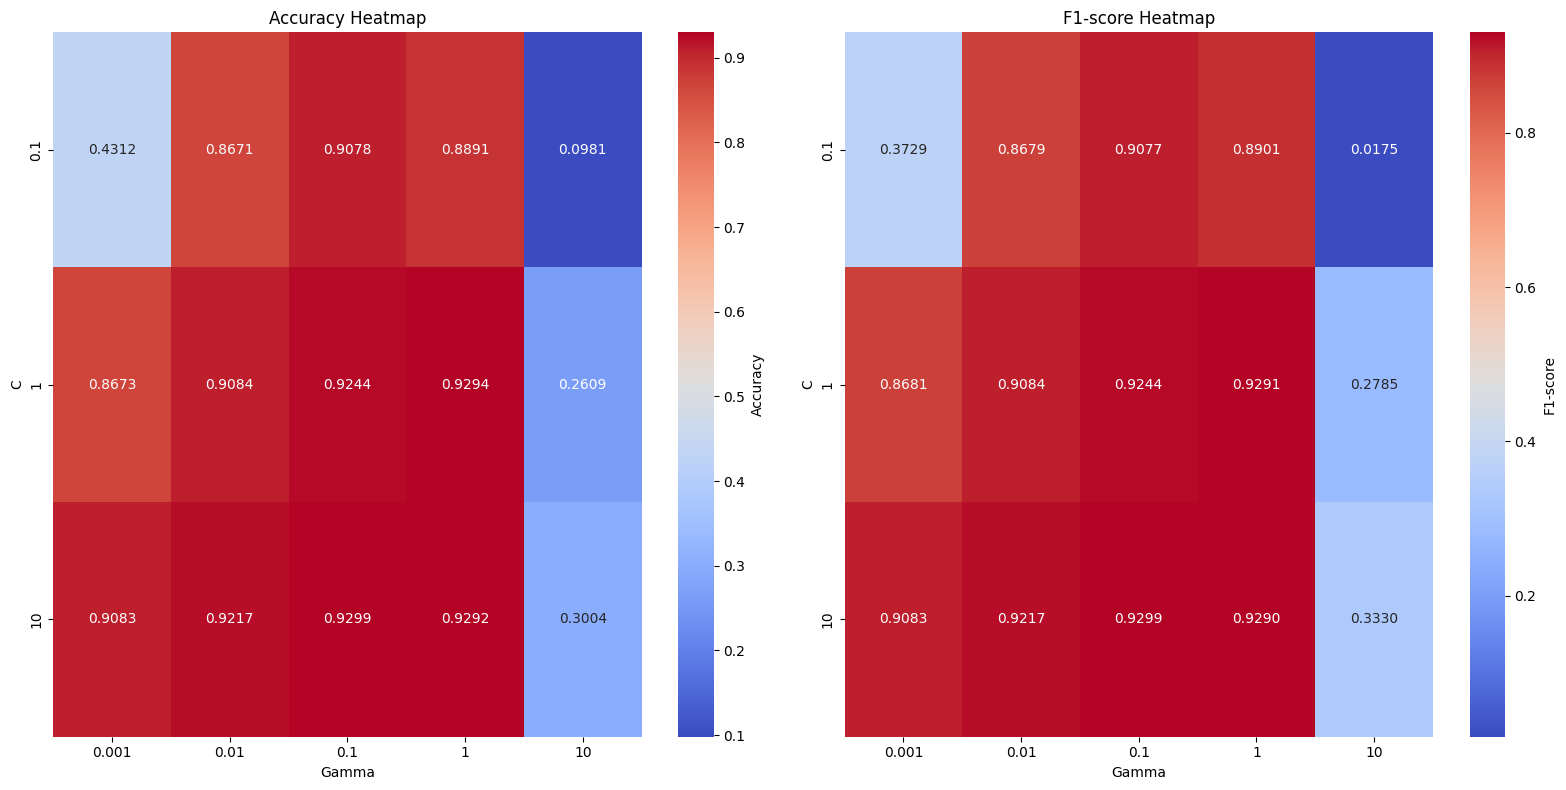

In [20]:
#plot graph
plot_heatmaps(
    results=results_svc,
    row_name='Gamma',
    row_values=param_grid_svc['gamma'],
    col_name='C',
    col_values=param_grid_svc['C'],
)


#### 4.2.Random Forest

In [21]:
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_leaf_nodes': [10, 16, 32],
}

# Perform cross-validation
results_rf = cross_validate_model(
    model_class = RandomForestClassifier,
    param_grid = param_grid_rf,
    X = train_features,
    y = train_labels,
    k = 5
)

Hyperparameters: {'max_leaf_nodes': 10, 'n_estimators': 100}
Average Test Accuracy: 0.8069, Average Test F1 Score: 0.7977
Average Training Time per Fold: 11.3769 seconds
Average Inference Time per Fold: 0.0268 seconds

Hyperparameters: {'max_leaf_nodes': 10, 'n_estimators': 300}
Average Test Accuracy: 0.8184, Average Test F1 Score: 0.8095
Average Training Time per Fold: 33.6760 seconds
Average Inference Time per Fold: 0.0698 seconds

Hyperparameters: {'max_leaf_nodes': 10, 'n_estimators': 500}
Average Test Accuracy: 0.8180, Average Test F1 Score: 0.8090
Average Training Time per Fold: 55.9632 seconds
Average Inference Time per Fold: 0.1302 seconds

Hyperparameters: {'max_leaf_nodes': 16, 'n_estimators': 100}
Average Test Accuracy: 0.8361, Average Test F1 Score: 0.8307
Average Training Time per Fold: 12.7839 seconds
Average Inference Time per Fold: 0.0269 seconds

Hyperparameters: {'max_leaf_nodes': 16, 'n_estimators': 300}
Average Test Accuracy: 0.8393, Average Test F1 Score: 0.8344
Av

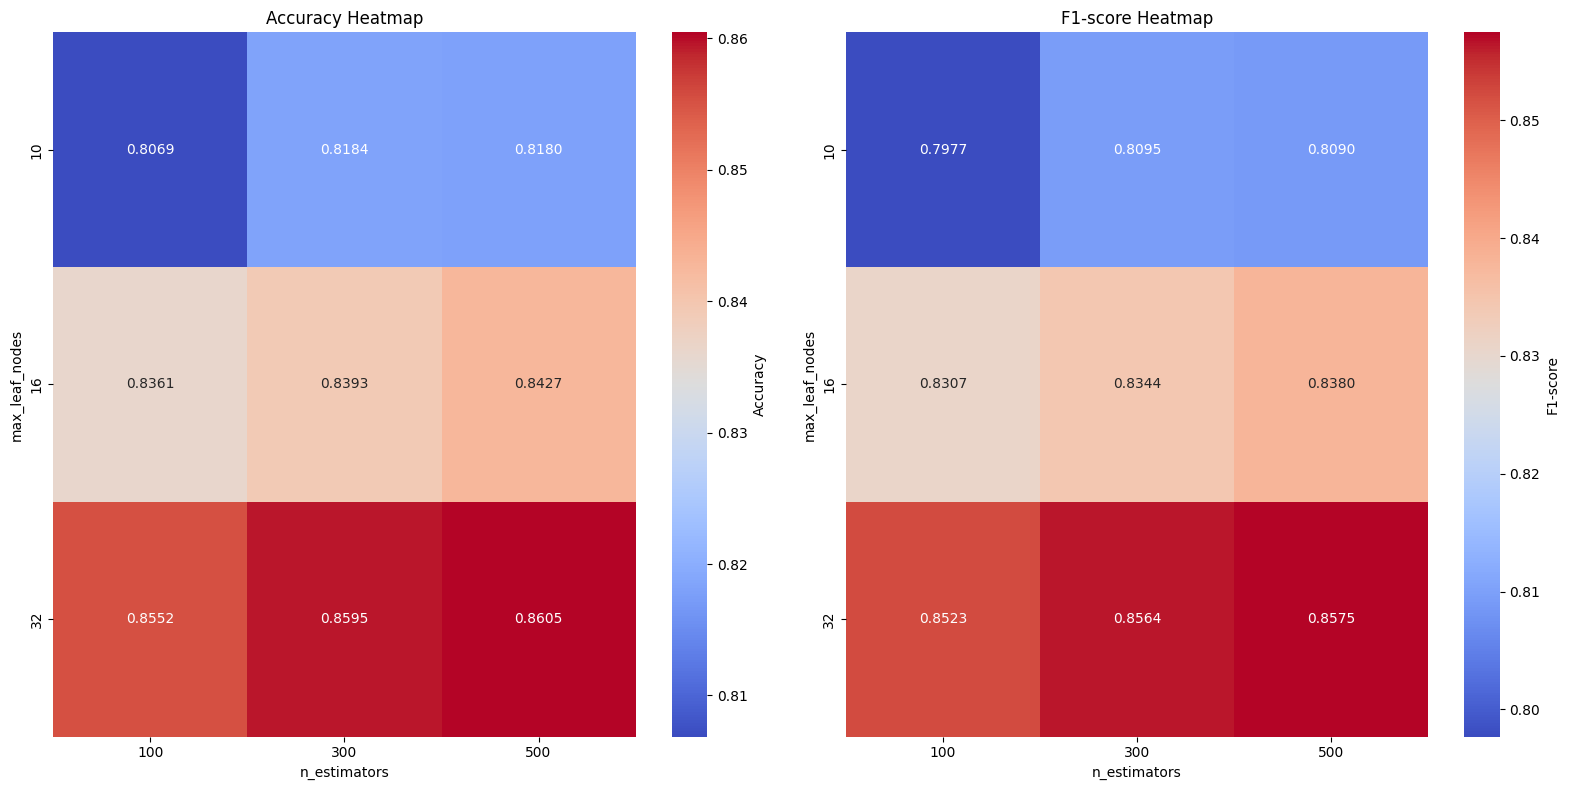

In [22]:
#plot graph
plot_heatmaps(
    results=results_rf,
    row_name='n_estimators',
    row_values=param_grid_rf['n_estimators'],
    col_name='max_leaf_nodes',
    col_values=param_grid_rf['max_leaf_nodes'],
)

#### 4.3.Logistic regression

In [23]:
param_grid_log = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'],
    'max_iter':[2000]
}

# Perform cross-validation
results_log = cross_validate_model(
    model_class = LogisticRegression,
    param_grid = param_grid_log,
    X = train_features,
    y = train_labels,
    k=5
)

Hyperparameters: {'C': 0.1, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'}
Average Test Accuracy: 0.9036, Average Test F1 Score: 0.9037
Average Training Time per Fold: 15.1188 seconds
Average Inference Time per Fold: 0.0014 seconds

Hyperparameters: {'C': 0.1, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'saga'}
Average Test Accuracy: 0.9116, Average Test F1 Score: 0.9116
Average Training Time per Fold: 1.6492 seconds
Average Inference Time per Fold: 0.0011 seconds

Hyperparameters: {'C': 1, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'}
Average Test Accuracy: 0.9179, Average Test F1 Score: 0.9179
Average Training Time per Fold: 38.7165 seconds
Average Inference Time per Fold: 0.0015 seconds

Hyperparameters: {'C': 1, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'saga'}
Average Test Accuracy: 0.9200, Average Test F1 Score: 0.9200
Average Training Time per Fold: 5.7035 seconds
Average Inference Time per Fold: 0.0013 seconds

Hyperparameters: {'C': 10, 'max_iter': 2000, 'pena

C:\Users\Owner\.conda\envs\pytorch_gpu\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Owner\.conda\envs\pytorch_gpu\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Owner\.conda\envs\pytorch_gpu\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Owner\.conda\envs\pytorch_gpu\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Average Test Accuracy: 0.9189, Average Test F1 Score: 0.9189
Average Training Time per Fold: 183.1356 seconds
Average Inference Time per Fold: 0.0013 seconds



C:\Users\Owner\.conda\envs\pytorch_gpu\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


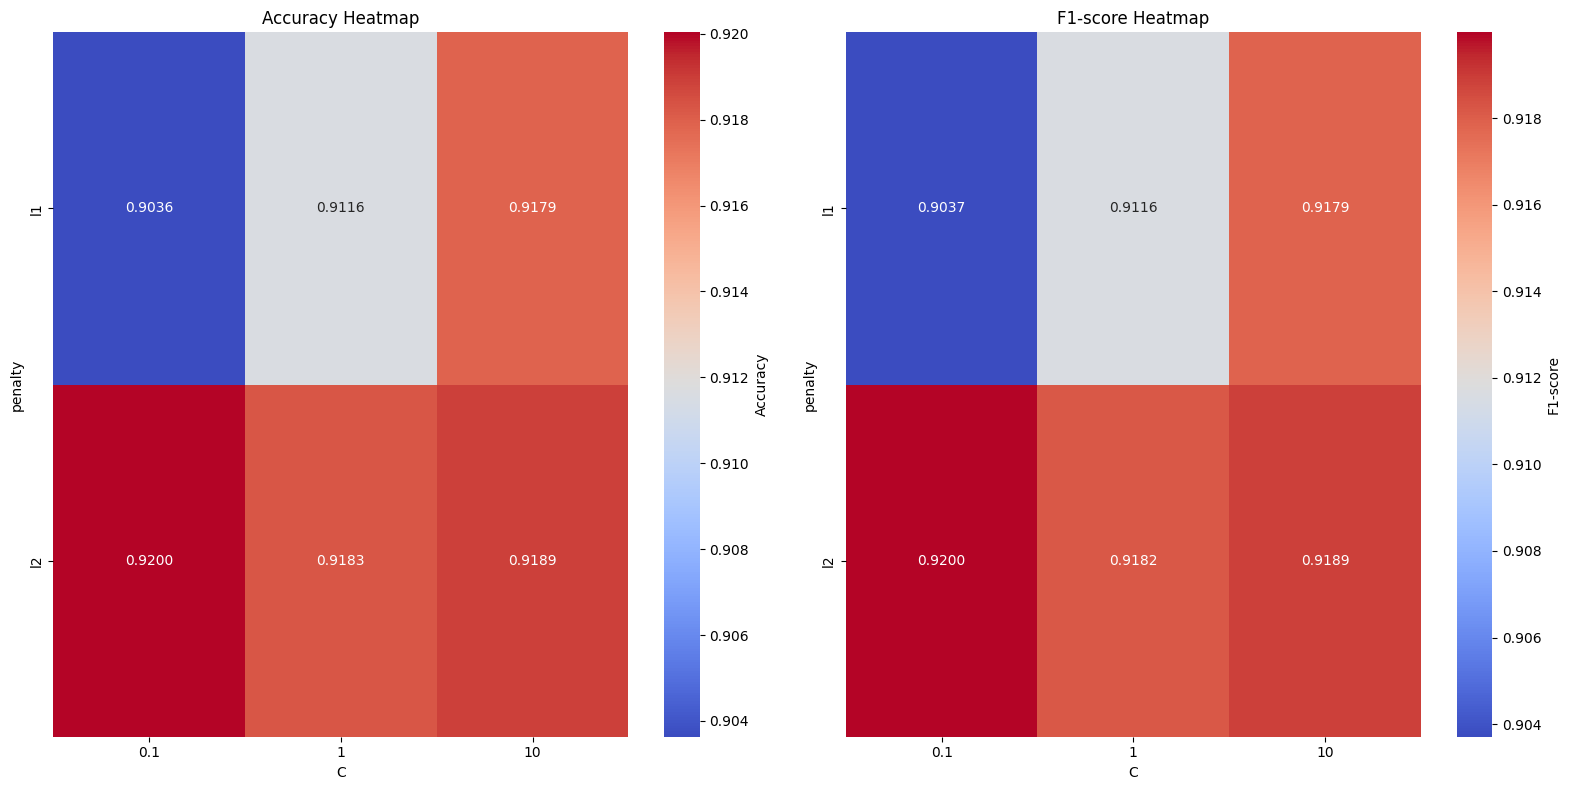

In [24]:
#plot graph
plot_heatmaps(
    results=results_log,
    row_name='C',
    row_values=param_grid_log['C'],
    col_name='penalty',
    col_values=param_grid_log['penalty'],
)

#### 4.4.KNN

In [25]:
param_grid_knn = {
    'n_neighbors': [5,7, 9, 11], 
    # 'weights': ['uniform','distance'], 
    'p': [1,2], 
    'algorithm': ['auto']
}

# Perform cross-validation
results_knn = cross_validate_model(
    model_class = KNeighborsClassifier,
    param_grid = param_grid_knn,
    X = train_features,
    y = train_labels,
    k=5
)

Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}
Average Test Accuracy: 0.9110, Average Test F1 Score: 0.9106
Average Training Time per Fold: 0.0025 seconds
Average Inference Time per Fold: 3.4611 seconds

Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2}
Average Test Accuracy: 0.9107, Average Test F1 Score: 0.9104
Average Training Time per Fold: 0.0020 seconds
Average Inference Time per Fold: 0.3618 seconds

Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1}
Average Test Accuracy: 0.9117, Average Test F1 Score: 0.9114
Average Training Time per Fold: 0.0020 seconds
Average Inference Time per Fold: 3.4354 seconds

Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2}
Average Test Accuracy: 0.9126, Average Test F1 Score: 0.9124
Average Training Time per Fold: 0.0020 seconds
Average Inference Time per Fold: 0.3681 seconds

Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1}
Average Test Accuracy: 0.9125, Average Test F1 

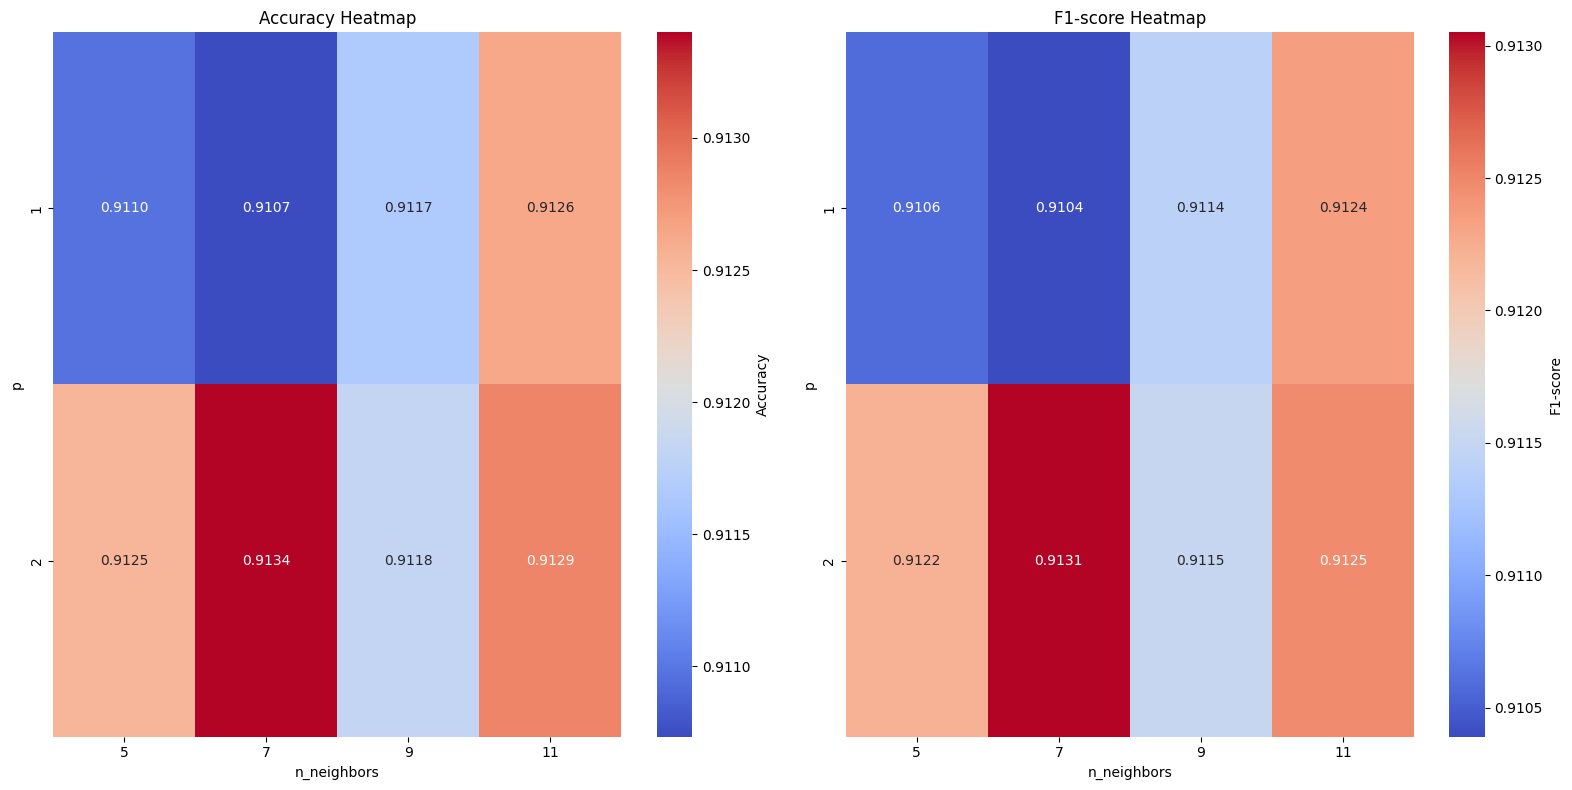

In [26]:
#plot graph
plot_heatmaps(
    results=results_knn,
    row_name='n_neighbors',
    row_values=param_grid_knn['n_neighbors'],
    col_name='p',
    col_values=param_grid_knn['p'],
)

### 5.Model Evaluation and Comparison 

In [27]:
result = []
models = [svm.SVC(C=10, gamma=1), RandomForestClassifier(n_estimators=300, max_leaf_nodes=32), 
          KNeighborsClassifier(n_neighbors = 7, p=2), LogisticRegression(C = 1, penalty = 'l2',solver='saga', max_iter=2000)]

#compare four models
for i in range(4):
    cur_model = models[i]
    start_time = time.perf_counter()
    cur_model.fit(train_features, train_labels)
    end_time = time.perf_counter()
    training_time = end_time - start_time
    print(f"training time: {training_time:.6f} seconds")
    
    start_time = time.perf_counter()
    test_pred = cur_model.predict(test_features)
    end_time = time.perf_counter()
    inference_time = end_time - start_time
    print(f"inference time: {inference_time:.6f} seconds")
    accuracy = accuracy_score(test_labels, test_pred)
    f1 = f1_score(test_labels, test_pred, average='weighted')
    print(f"Test Accuracy: {accuracy}")

    result.append([accuracy, f1, training_time, inference_time])

training time: 19.858724 seconds
inference time: 2.346534 seconds
Test Accuracy: 0.929
training time: 60.239416 seconds
inference time: 0.038406 seconds
Test Accuracy: 0.8615
training time: 0.002148 seconds
inference time: 0.170014 seconds
Test Accuracy: 0.914
training time: 7.371753 seconds
inference time: 0.001056 seconds
Test Accuracy: 0.9235


In [28]:
result

[[0.929,
  np.float64(0.9283764404058119),
  19.858724499994423,
  2.3465344000142068],
 [0.8615,
  np.float64(0.8585224586685365),
  60.23941589996684,
  0.03840570000465959],
 [0.914,
  np.float64(0.9135174186703224),
  0.002147899998817593,
  0.170013899973128],
 [0.9235,
  np.float64(0.9233699825512889),
  7.371752500010189,
  0.0010561999515630305]]

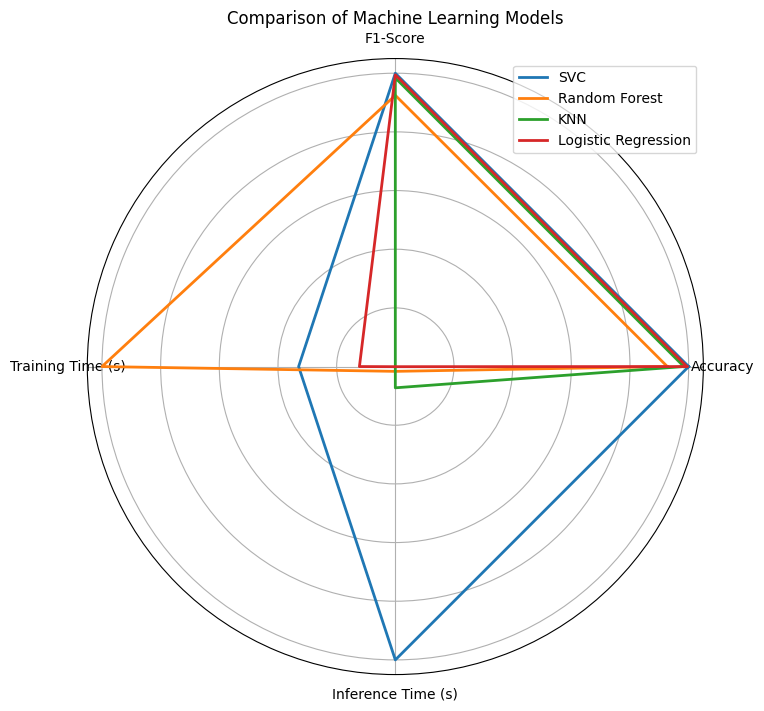

In [29]:
#plot 
result = np.array(result)
categories = ['Accuracy', 'F1-Score', 'Training Time (s)', 'Inference Time (s)']
models = ['SVC', 'Random Forest', 'KNN', 'Logistic Regression']

result_normalized = result  / result.max(axis=0)
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, model_data in enumerate(result_normalized):
    values = model_data.tolist()
    values += values[:1]  
    ax.plot(angles, values, linewidth=2, label=models[i])

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

ax.legend()
plt.title('Comparison of Machine Learning Models')
plt.show()

### 6.Predict with best classifier

In [30]:
#predict
final_model = svm.SVC(C=10, gamma=1)
final_model.fit(train_features, train_labels)
prediction = final_model.predict(predict_features).reshape(-1, 1)

In [31]:
#generate indice
indices = np.arange(len(prediction)).reshape(-1, 1)
#concate 
indexed_array = np.hstack((indices, prediction))

In [32]:
indexed_array.shape

(5000, 2)

In [33]:
#save result
df = pd.DataFrame(indexed_array, columns = ['id','label'])
df
df.to_csv(r'test_output.csv', index=False)

### Reference of the package

#### 1.pytorch https://pytorch.org/ 
#### The deep learning model was not based on a public model, it was self-designed and trained.
#### 2.tqdm https://tqdm.github.io/
#### 3.seaborn https://seaborn.pydata.org/